# FMCA Samplet GP Filtering on SimOcean Data

We can use samplets for kernel filtering, that is we represent the kernel in a samplet basis and pick the diagonal subblock containing the largest diagonal elements. This way, we can even deal with highly ill conditioned kernels
and arbitrary data sizes.

### first import modules

In [2]:
# import seems necessary to not crash matplotlib
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg as la
import scipy
import scipy.sparse.linalg as sla
import time
import FMCA

### Create data points
(We force NumPy to use column major arrays for performance reasons)

In [3]:
import pandas  as pd 

df = pd.read_excel('Case5_1st_launch_WingsConvCoeffs_Info.xlsx')
df.head()

data = np.vstack([df["alpha0"].to_numpy().astype(np.float64),
                                df["alpha1"].to_numpy().astype(np.float64),
                                df["Cy0Mean"].to_numpy().astype(np.float64)])
# col-major reorder
my_data = np.array(np.sort(data),order='F')
print(my_data.shape)
pts = my_data[:2,:]




(3, 1296)


(1296, 1296)


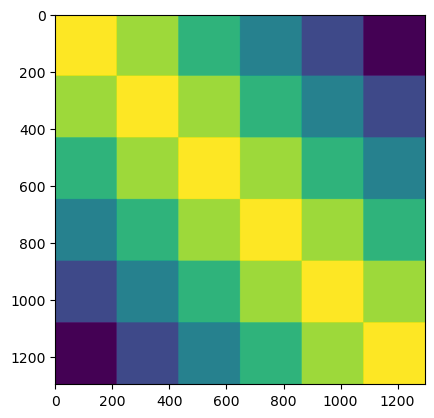

In [4]:
cov = FMCA.CovarianceKernel("MATERN32", 1.)
cov_eval = cov.eval(pts,pts)
print(cov_eval.shape)
plt.imshow(np.log(cov_eval))
plt.show()

time tree setup:              0.060918331146240234 sec.
time kernel compression:      0.09120392799377441 sec.


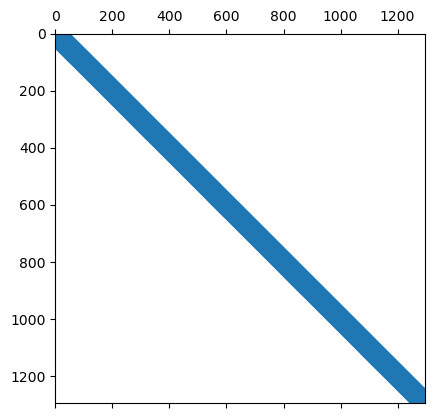

In [5]:
dtilde = 10
start = time.time()

ST = FMCA.SampletTree(pts, dtilde)
stop = time.time()
print('time tree setup:             ', stop - start, 'sec.')
start = time.time()
SKC = FMCA.SampletKernelCompressor(ST, cov, pts, 1., 1e-6)
stop = time.time()
print('time kernel compression:     ', stop - start, 'sec.')
# return matrix and create lower triangular part
K = SKC.matrix()

K = K + scipy.sparse.triu(K, k=1).transpose()
plt.spy(K)
plt.show()

## filter the kernel matrix
in Samplet basis, we now filter the relevant frequencies by simple diagonal pivoting (!!!) the remaining number of coefficients is steered by the parameter number_of_coefficients

filtered kernel error:        0.30173511446216994
condition number:             657796944287.5055


c:\Users\david\miniconda3\envs\dataEnergy\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


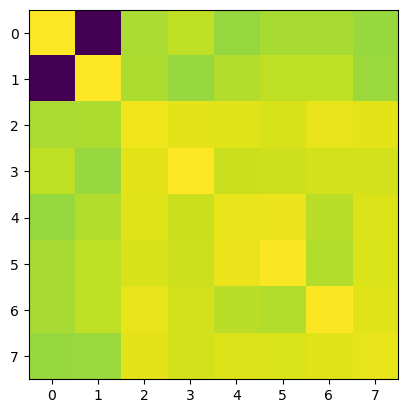

In [6]:
number_of_coefficients = 8
idx = np.sort((-K.diagonal()).argsort()[:number_of_coefficients])
Ksmall = K[np.ix_(idx,idx)]
N = K.shape[0]
Kemb = scipy.sparse.csr_matrix((N,N))
Kemb[np.ix_(idx,idx)] = Ksmall
print('filtered kernel error:       ', sla.norm(K-Kemb)/sla.norm(K))
print('condition number:            ', la.cond(Ksmall.todense()))
plt.imshow(np.log(np.abs(Ksmall.todense())+1e-16))
plt.show()

## now filter data and solve the linear system

In [34]:
# Reorder the output and input based on ST indices .
output = my_data[2,:]
y = output[ST.indices()]
spts = pts[:,ST.indices()]
# Transform y in new coordinate 
Ty = FMCA.sampletTransform(ST, y.transpose())
Tysmall = Ty[idx,:];
Talpha = la.solve(Ksmall.todense(), Tysmall)
r = Tysmall - Ksmall @ Talpha
print('residual:                    ', la.norm(r)/la.norm(Tysmall))
Talphaemb = np.zeros(Ty.shape)
Talphaemb[idx,:] = Talpha
alpha = FMCA.inverseSampletTransform(ST, Talphaemb)

residual:                     1.1073234270521675e-07


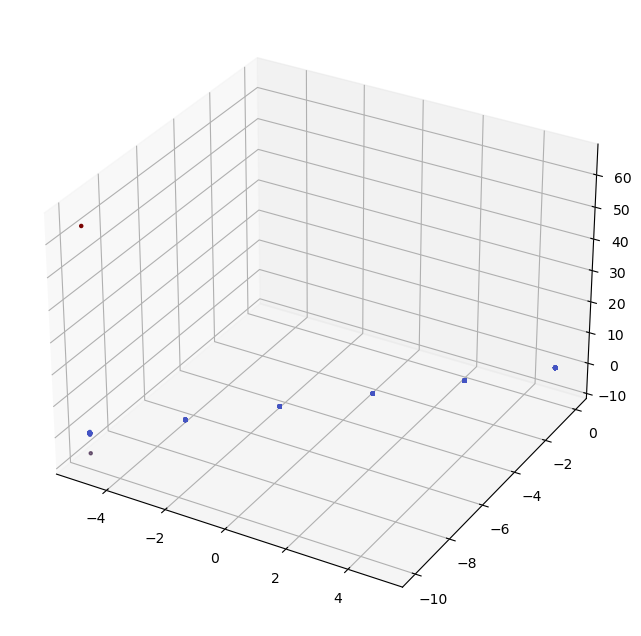

In [35]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter(spts[0,:], spts[1,:], Ty, c=Ty, marker='.', cmap='turbo')
plt.show()


## evaluate kernel interpolant

In [33]:
y = output[ST.indices()]

Keval = cov.eval(spts, spts)

r = y.reshape(-1,1) - Keval @ alpha


print('residual:                    ', la.norm(r)/la.norm(y))

residual:                     0.09772358715223767
